### 整合性

$a_{jk}^\text{L} w_k^\text{U} = w_j^\text{L}, ~ a_{jk}^\text{U} w_k^\text{L} = w_j^\text{U}, w_j^\text{L} \leq w_j^\text{U}, ~ j, k \in N, ~ j \neq k$ を満たす解が唯一存在することの必要十分条件は次の通り．

任意の $i \in N$ について次の式すべてが成り立つ．
$$
a_{ij}^\text{L} a_{jk}^\text{U} a_{ki}^\text{L} = a_{is}^\text{L} a_{sr}^\text{U} a_{ri}^\text{L}, ~~
j \neq k, ~~ s \neq r, ~~ j, k, s, r \in N \backslash \{ i \}
$$

$$
a_{ij}^\text{L} a_{jk}^\text{U} a_{ki}^\text{L} \leq 1, ~~
a_{si}^\text{L} \leq a_{sr}^\text{U} a_{ri}^\text{L}, ~~
j \neq k, ~~ s \neq r, ~~ j, k, s, r \in N \backslash \{ i \}
$$

$$
\begin{aligned}
& \min \left(
    a_{ij}^\text{L} a_{jk}^\text{U} a_{ki}^\text{L} +
    a_{jk}^\text{U} a_{ki}^\text{L} +
    \sum_{r \in N \backslash \{ i, j \}} a_{rj}^\text{U} a_{ji}^\text{L}, ~
    \min_{r \in N \backslash \{ i \}} \left(
        a_{ri}^\text{L} + 1 + \sum_{s \in N \backslash \{ i, r \}} a_{sr}^\text{U} a_{ri}^\text{L}
    \right)
\right) \\ & ~~~~
\geq \max\left(
    1 + \sum_{r \in N \backslash \{ i \}} a_{ri}^\text{L}, ~~
    a_{jk}^\text{U} a_{ki}^\text{L} +
    a_{ij}^\text{L} a_{jk}^\text{U} a_{ki}^\text{L} +
    \sum_{r \in N \backslash \{ i, j \}} a_{ri}^\text{L},
    \right. \\ & \hspace{50pt} \left.
    \max_{r \in N \backslash \{ i, j \}} \left(
        a_{rj}^\text{U} a_{ji}^\text{L} +
        a_{ij}^\text{L} a_{jk}^\text{U} a_{ki}^\text{L} +
        \sum_{s \in N \backslash \{ i, r \}} a_{ri}^\text{L}
    \right)
\right).
\end{aligned}
$$

上 ２ つで解の存在性を担保できる． 3 つ目は解の唯一性に関連する．

In [45]:
using IntervalArithmetic
using LaTeXStrings
using Plots

In [46]:
include("./heatmap/index.jl")
include("./method1/index.jl")
include("./method2/index.jl")
include("./method3/index.jl")
include("./method4/index.jl")
include("./intervalPCM/index.jl")
include("./twofoldInterval/index.jl")
include("./twofoldIntervalPCM/index.jl")

print()

In [47]:
function method1(A₁::Matrix{Interval{T}}, A₂::Matrix{Interval{T}}) where {T <: Real}
    A = intervalPCM2TwofoldIntervalPCM(A₁, A₂)
    result = solveLP_m1(A)
    Â = updatePCM_m1(A, result)
    return Â
end

method1 (generic function with 1 method)

In [48]:
function  method2(A₁::Matrix{Interval{T}}, A₂::Matrix{Interval{T}}) where {T <: Real}
    εᶿ = solveIndividualCancellingLP_m2([A₁, A₂])
    result = solveApproximationLP_m2([A₁, A₂], εᶿ)
    A = importance2TwofoldIntervalPCM_m2(result)
    return A
end

method2 (generic function with 1 method)

In [49]:
function method3(A₁::Matrix{Interval{T}}, A₂::Matrix{Interval{T}}) where {T <: Real}
    approximationResults = solveApproximationLP_m3.([A₁, A₂])
    tBoundaries = calculateTBoundaries_m3.(approximationResults)
    result = solveConcatLP_m3(approximationResults, tBoundaries)
    Â = generatePCM_m3(result)
    return Â
end

method3 (generic function with 1 method)

In [50]:
function method4(A₁::Matrix{Interval{T}}, A₂::Matrix{Interval{T}}) where {T <: Real}
    results = solveApproximationLP_m4.([A₁, A₂])
    A = generateTwofoldIntervalMatrix_m4(results)
    result = solveCancellingLP_m4(A)
    Â = updatePCM_m4(A, result)
    return Â
end

method4 (generic function with 1 method)

In [51]:
# 対角成分以外の算術平均
function mean(A::Matrix{T})::T where {T <: Real}
    m, n = size(A)

    if m != n return 0 end
    if n == 1 return 0 end

    a = 0
    for i = 1:m, j = 1:n
        if i == j continue end
        a += A[i,j]
    end

    return a / n / (n-1)
end

titles = [
    "行列を結合して二重区間PCMを作り，整合化",
    "整合化しながら結合した重要度を求めて二重区間PCMにする",
    "DMごとに重要度の上・下近似を求めて重要度として結合し，二重区間PCMにする",
    "DMごとに重要度の上・下近似を求めて二重区間PCMにして，一つの二重区間PCMに結合して整合化"
]

function plotAll(A₁::Matrix{Interval{T}}, A₂::Matrix{Interval{T}}, size::Tuple{Integer, Integer}=(1000, 250)) where {T <: Real}
    m = 2 # DM の数

    matrices = [A₁, A₂]
    resultMatrices = twofoldIntervalMatrix2intervalMatrices.(
        [method1(A₁, A₂), method2(A₁, A₂), method3(A₁, A₂), method4(A₁, A₂)])
    
    p = []; a = []; indmat = []
    for k = 1:length(resultMatrices)
        h = []; indrow = []
        Âₖ⁻, Âₖ⁺ = resultMatrices[k]
        for l = 1:m
            title⁻ = L"S( A_{%$(l)ij}, \mathscr{A}_{ij}^{%$(k)-} )"
            title⁺ = L"S( A_{%$(l)ij}, \mathscr{A}_{ij}^{%$(k)+} )"

            heatmap⁻, indices⁻ = plotConincidenceIndices(matrices[l], Âₖ⁻, title⁻)
            heatmap⁺, indices⁺ = plotConincidenceIndices(matrices[l], Âₖ⁺, title⁺)

            push!(h, heatmap⁻); push!(h, heatmap⁺)
            push!(indrow, indices⁻); push!(indrow, indices⁺)
        end

        push!(p, h); push!(a, [Âₖ⁻, Âₖ⁺])
        push!(indmat, indrow)
    end

    for i = eachindex(p)
        display(titles[i])
        A = intervalPCM2TwofoldIntervalPCM(a[i][1], a[i][2])
        display(L"\hat{A}_{%$(i)} = %$(twofoldIntervalMatrixLaTeXString(A))")
        display(plot(p[i]..., layout=(1, 4), size=size, legend=false))
        display(L"\sigma^{%$(i)-} = %$(round(2\sum(mean.([indmat[i][1], indmat[i][3]])), digits=3))")
        display(L"\sigma^{%$(i)+} = %$(round(2\sum(mean.([indmat[i][2], indmat[i][4]])), digits=3))")
        # display("非対角成分の算術平均: $(round(mean(indmat[i][1]), digits=3)), $(round(mean(indmat[i][2]), digits=3)), $(round(mean(indmat[i][3]), digits=3)), $(round(mean(indmat[i][4]), digits=3))")
    end
end

plotAll (generic function with 2 methods)

In [52]:
A₁ = [
    1..1 (1/2)..2 (1/2)..2
    (1/2)..2 1..1 (1/2)..2
    (1/2)..2 (1/2)..2 1..1
]
_, n = size(A₁)
A₂ = fill(1..1, (n, n))
for i = 1:n, j = 1:n
    if i == j continue end
    A₂[i,j] = (A₁[i,j].lo * 4 / 5)..(A₁[i,j].hi * 5 / 4)
end

isConsistentIntervalPCM(A₂)

true

整合している同じ行列 2 つ

L"$A_1 = \begin{bmatrix} \left[ 1.0, 1.0 \right] & \left[ 0.5, 2.0 \right] & \left[ 0.5, 2.0 \right] \\ \left[ 0.5, 2.0 \right] & \left[ 1.0, 1.0 \right] & \left[ 0.5, 2.0 \right] \\ \left[ 0.5, 2.0 \right] & \left[ 0.5, 2.0 \right] & \left[ 1.0, 1.0 \right] \end{bmatrix}$"

L"$A_2 = \begin{bmatrix} \left[ 1.0, 1.0 \right] & \left[ 0.4, 2.5 \right] & \left[ 0.4, 2.5 \right] \\ \left[ 0.4, 2.5 \right] & \left[ 1.0, 1.0 \right] & \left[ 0.4, 2.5 \right] \\ \left[ 0.4, 2.5 \right] & \left[ 0.4, 2.5 \right] & \left[ 1.0, 1.0 \right] \end{bmatrix}$"

true

true

"行列を結合して二重区間PCMを作り，整合化"

"\$\\hat{A}_{1} = \\begin{bmatrix} \\left[   1.0, \\left[   1.0,   1.0 \\right],   1.0 \\right] & \\left[   0.4, \\left[   0.4,   2.5 \\right],   2.5 \\right] & \\left[   0.4, \\left[   0.4,   2.5 \\right],   2.5 \\right] \\\\ \\left[   0.4, \\left[   0.4,   2.5 \\right],   2.5 \\right] & \\le" ⋯ 34 bytes ⋯ "ght],   1.0 \\right] & \\left[   0.4, \\left[   0.4,   2.5 \\right],   2.5 \\right] \\\\ \\left[   0.4, \\left[   0.4,   2.5 \\right],   2.5 \\right] & \\left[   0.4, \\left[   0.4,   2.5 \\right],   2.5 \\right] & \\left[   1.0, \\left[   1.0,   1.0 \\right],   1.0 \\right] \\end{bmatrix}\$"

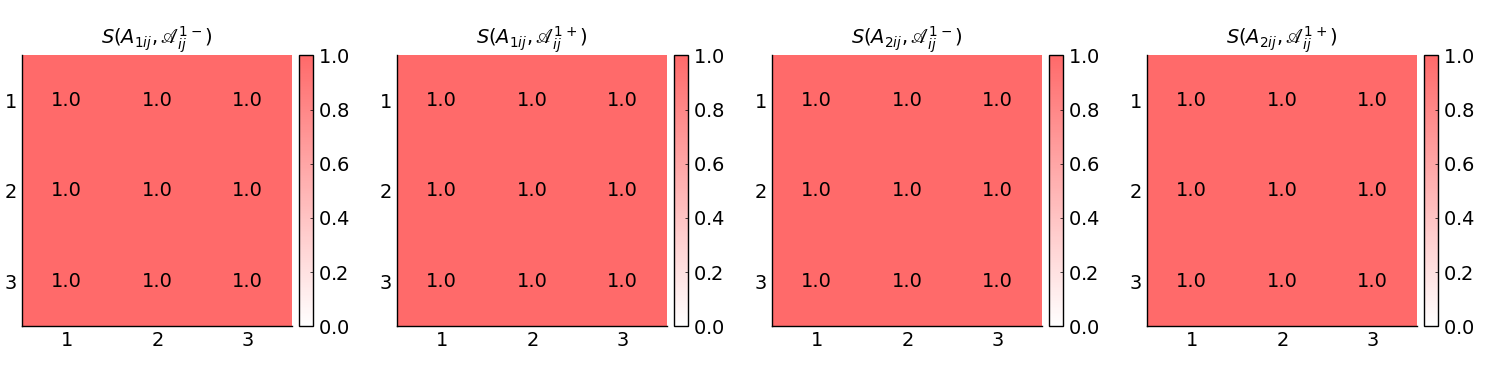

L"$\sigma^{1-} = 1.0$"

L"$\sigma^{1+} = 1.0$"

"整合化しながら結合した重要度を求めて二重区間PCMにする"

"\$\\hat{A}_{2} = \\begin{bmatrix} \\left[   1.0, \\left[   1.0,   1.0 \\right],   1.0 \\right] & \\left[   0.4, \\left[   0.4,   2.5 \\right],   2.5 \\right] & \\left[   0.4, \\left[   0.4,   2.5 \\right],   2.5 \\right] \\\\ \\left[   0.4, \\left[   0.4,   2.5 \\right],   2.5 \\right] & \\le" ⋯ 34 bytes ⋯ "ght],   1.0 \\right] & \\left[   0.4, \\left[   0.4,   2.5 \\right],   2.5 \\right] \\\\ \\left[   0.4, \\left[   0.4,   2.5 \\right],   2.5 \\right] & \\left[   0.4, \\left[   0.4,   2.5 \\right],   2.5 \\right] & \\left[   1.0, \\left[   1.0,   1.0 \\right],   1.0 \\right] \\end{bmatrix}\$"

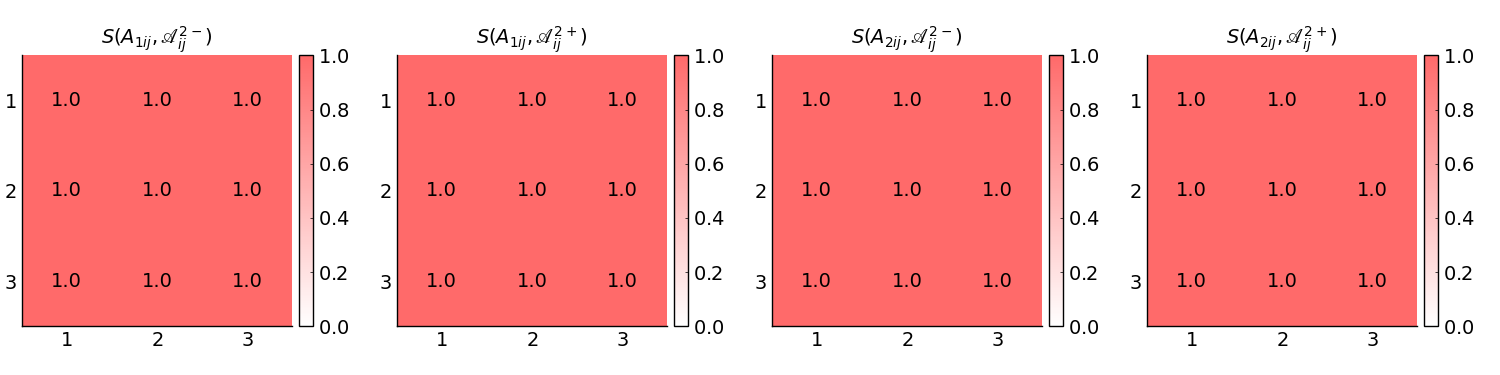

L"$\sigma^{2-} = 1.0$"

L"$\sigma^{2+} = 1.0$"

"DMごとに重要度の上・下近似を求めて重要度として結合し，二重区間PCMにする"

"\$\\hat{A}_{3} = \\begin{bmatrix} \\left[   1.0, \\left[   1.0,   1.0 \\right],   1.0 \\right] & \\left[   0.4, \\left[   0.4,   2.5 \\right],   2.5 \\right] & \\left[   0.4, \\left[   0.4,   2.5 \\right],   2.5 \\right] \\\\ \\left[   0.4, \\left[   0.4,   2.5 \\right],   2.5 \\right] & \\le" ⋯ 34 bytes ⋯ "ght],   1.0 \\right] & \\left[   0.4, \\left[   0.4,   2.5 \\right],   2.5 \\right] \\\\ \\left[   0.4, \\left[   0.4,   2.5 \\right],   2.5 \\right] & \\left[   0.4, \\left[   0.4,   2.5 \\right],   2.5 \\right] & \\left[   1.0, \\left[   1.0,   1.0 \\right],   1.0 \\right] \\end{bmatrix}\$"

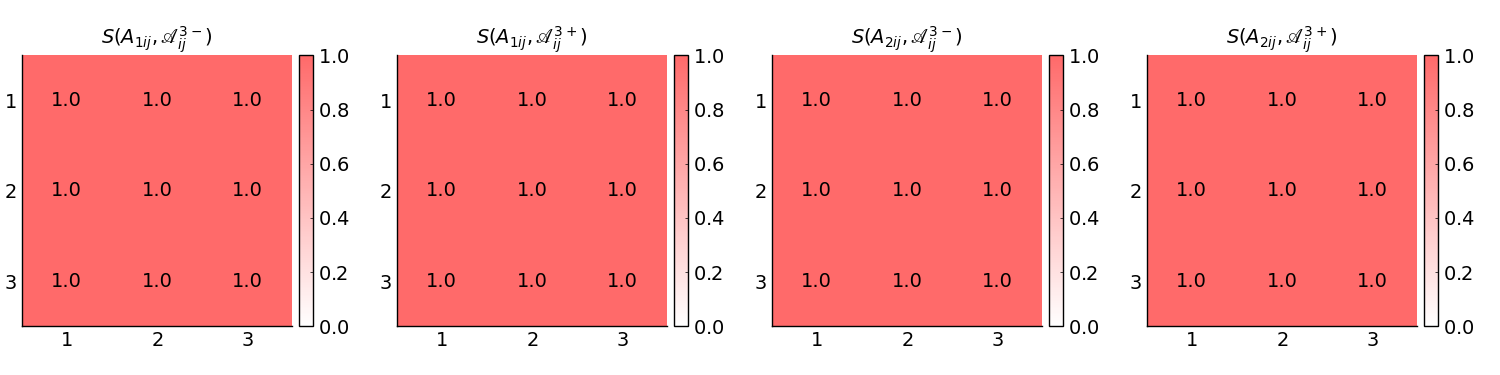

L"$\sigma^{3-} = 1.0$"

L"$\sigma^{3+} = 1.0$"

"DMごとに重要度の上・下近似を求めて二重区間PCMにして，一つの二重区間PCMに結合して整合化"

"\$\\hat{A}_{4} = \\begin{bmatrix} \\left[   1.0, \\left[   1.0,   1.0 \\right],   1.0 \\right] & \\left[   0.4, \\left[   0.4,   2.5 \\right],   2.5 \\right] & \\left[   0.4, \\left[   0.4,   2.5 \\right],   2.5 \\right] \\\\ \\left[   0.4, \\left[   0.4,   2.5 \\right],   2.5 \\right] & \\le" ⋯ 34 bytes ⋯ "ght],   1.0 \\right] & \\left[   0.4, \\left[   0.4,   2.5 \\right],   2.5 \\right] \\\\ \\left[   0.4, \\left[   0.4,   2.5 \\right],   2.5 \\right] & \\left[   0.4, \\left[   0.4,   2.5 \\right],   2.5 \\right] & \\left[   1.0, \\left[   1.0,   1.0 \\right],   1.0 \\right] \\end{bmatrix}\$"

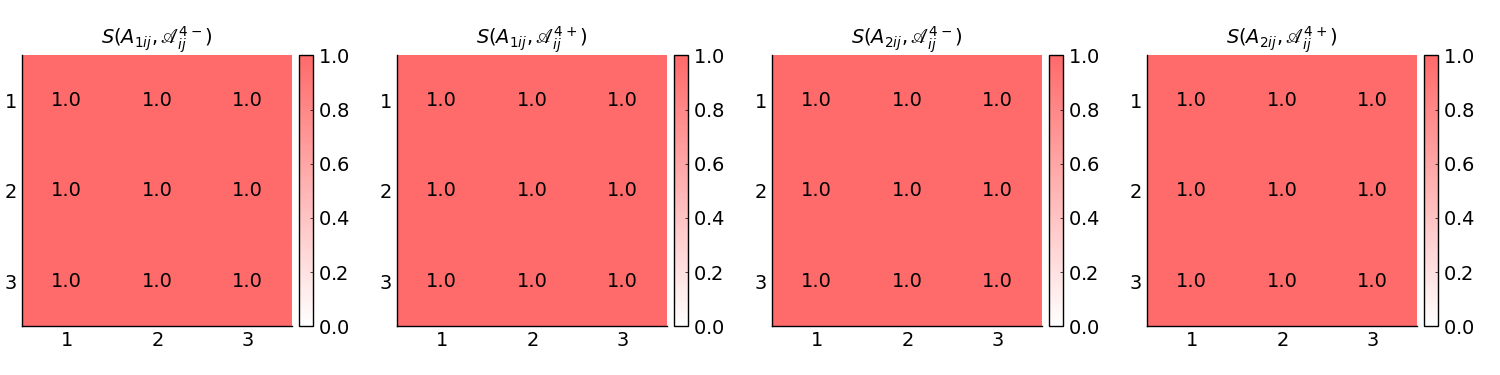

L"$\sigma^{4-} = 1.0$"

L"$\sigma^{4+} = 1.0$"

In [53]:
A₁ = [
    1..1 (1/2)..2 (1/2)..2
    (1/2)..2 1..1 (1/2)..2
    (1/2)..2 (1/2)..2 1..1
]
_, n = size(A₁)
A₂ = fill(1..1, (n, n))
for i = 1:n, j = 1:n
    if i == j continue end
    A₂[i,j] = (A₁[i,j].lo * 4 / 5)..(A₁[i,j].hi * 5 / 4)
end

display(L"A_1 = %$(intervalMatrixLaTeXString(A₁))")
display(L"A_2 = %$(intervalMatrixLaTeXString(A₂))")

display(isConsistentIntervalPCM(A₁))
display(isConsistentIntervalPCM(A₂))

plotAll(A₂, A₂, (1500, 375))

ともに整合していて， $A_{1ij} \subseteq A_{2ij}$

L"$A_1 = \begin{bmatrix} \left[ 1.0, 1.0 \right] & \left[ 1.0, 2.0 \right] & \left[ 0.667, 1.333 \right] & \left[ 1.0, 1.333 \right] \\ \left[ 0.5, 1.0 \right] & \left[ 1.0, 1.0 \right] & \left[ 0.444, 1.0 \right] & \left[ 0.667, 1.0 \right] \\ \left[ 0.75, 1.5 \right] & \left[ 1.0, 2.25 \right] & \left[ 1.0, 1.0 \right] & \left[ 1.0, 1.5 \right] \\ \left[ 0.75, 1.0 \right] & \left[ 1.0, 1.5 \right] & \left[ 0.667, 1.0 \right] & \left[ 1.0, 1.0 \right] \end{bmatrix}$"

L"$A_2 = \begin{bmatrix} \left[ 1.0, 1.0 \right] & \left[ 0.8, 2.5 \right] & \left[ 0.533, 1.667 \right] & \left[ 0.8, 1.667 \right] \\ \left[ 0.4, 1.25 \right] & \left[ 1.0, 1.0 \right] & \left[ 0.356, 1.25 \right] & \left[ 0.533, 1.25 \right] \\ \left[ 0.6, 1.875 \right] & \left[ 0.8, 2.812 \right] & \left[ 1.0, 1.0 \right] & \left[ 0.8, 1.875 \right] \\ \left[ 0.6, 1.25 \right] & \left[ 0.8, 1.875 \right] & \left[ 0.533, 1.25 \right] & \left[ 1.0, 1.0 \right] \end{bmatrix}$"

false

false

"行列を結合して二重区間PCMを作り，整合化"

"\$\\hat{A}_{1} = \\begin{bmatrix} \\left[   1.0, \\left[   1.0,   1.0 \\right],   1.0 \\right] & \\left[   0.8, \\left[   1.0,   2.0 \\right],   2.5 \\right] & \\left[ 0.533, \\left[ 0.667, 1.333 \\right], 1.667 \\right] & \\left[   0.8, \\left[   1.0, 1.333 \\right], 1.667 \\right] \\\\ \\le" ⋯ 449 bytes ⋯ "ht], 1.875 \\right] \\\\ \\left[   0.6, \\left[  0.75,   1.0 \\right],  1.25 \\right] & \\left[   0.8, \\left[   1.0,   1.5 \\right], 1.875 \\right] & \\left[ 0.533, \\left[ 0.667,   1.0 \\right],  1.25 \\right] & \\left[   1.0, \\left[   1.0,   1.0 \\right],   1.0 \\right] \\end{bmatrix}\$"

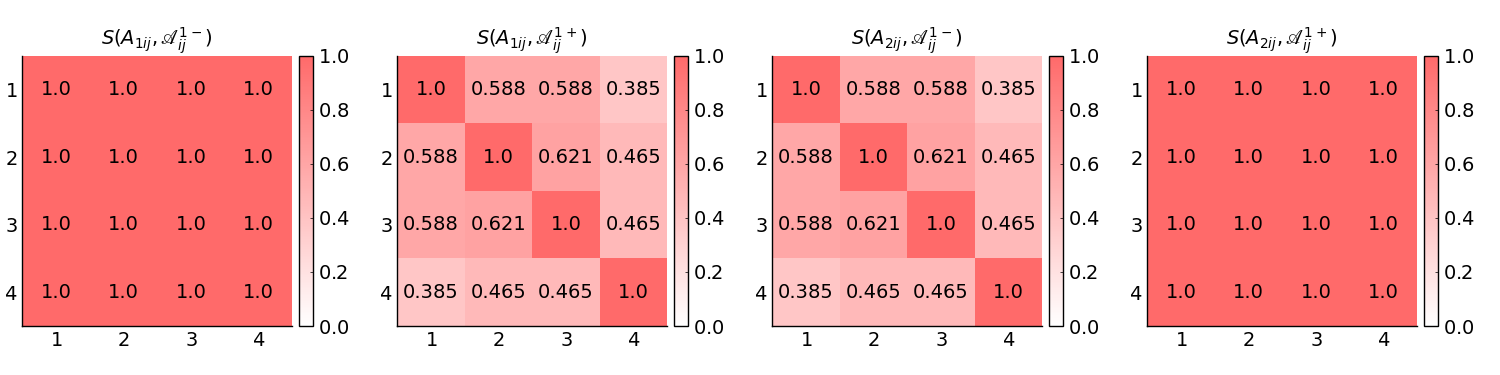

L"$\sigma^{1-} = 0.759$"

L"$\sigma^{1+} = 0.759$"

"整合化しながら結合した重要度を求めて二重区間PCMにする"

"\$\\hat{A}_{2} = \\begin{bmatrix} \\left[   1.0, \\left[   1.0,   1.0 \\right],   1.0 \\right] & \\left[   0.8, \\left[   1.0,   2.0 \\right],   2.5 \\right] & \\left[ 0.533, \\left[ 0.667, 1.333 \\right], 1.667 \\right] & \\left[   0.8, \\left[   1.0, 1.333 \\right], 1.667 \\right] \\\\ \\le" ⋯ 449 bytes ⋯ "ht], 1.875 \\right] \\\\ \\left[   0.6, \\left[  0.75,   1.0 \\right],  1.25 \\right] & \\left[   0.8, \\left[   1.0,   1.5 \\right], 1.875 \\right] & \\left[ 0.533, \\left[ 0.667,   1.0 \\right],  1.25 \\right] & \\left[   1.0, \\left[   1.0,   1.0 \\right],   1.0 \\right] \\end{bmatrix}\$"

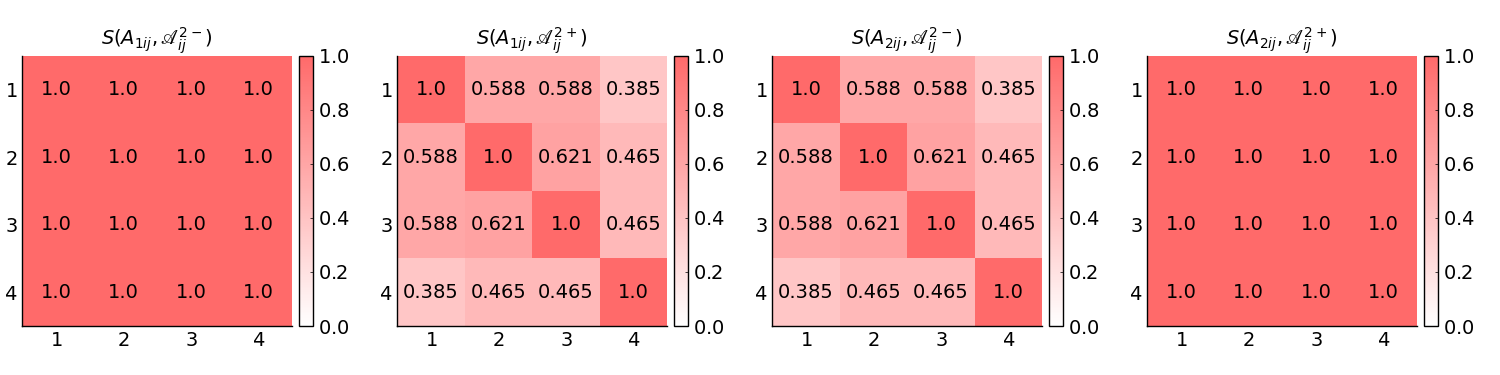

L"$\sigma^{2-} = 0.759$"

L"$\sigma^{2+} = 0.759$"

"DMごとに重要度の上・下近似を求めて重要度として結合し，二重区間PCMにする"

"\$\\hat{A}_{3} = \\begin{bmatrix} \\left[   1.0, \\left[   1.0,   1.0 \\right],   1.0 \\right] & \\left[   0.8, \\left[ 0.992,   2.0 \\right],   2.5 \\right] & \\left[ 0.533, \\left[ 0.667, 1.333 \\right], 1.667 \\right] & \\left[   0.8, \\left[ 0.992, 1.333 \\right], 1.667 \\right] \\\\ \\le" ⋯ 449 bytes ⋯ "ht],  1.86 \\right] \\\\ \\left[   0.6, \\left[  0.75, 1.008 \\right],  1.25 \\right] & \\left[   0.8, \\left[   1.0,   1.5 \\right], 1.875 \\right] & \\left[ 0.538, \\left[ 0.667,   1.0 \\right],  1.25 \\right] & \\left[   1.0, \\left[   1.0,   1.0 \\right],   1.0 \\right] \\end{bmatrix}\$"

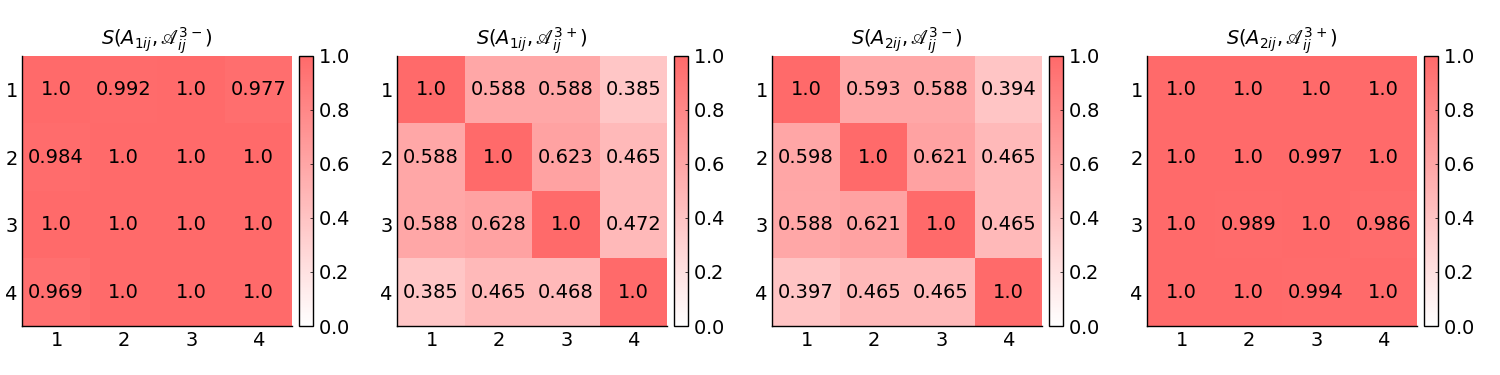

L"$\sigma^{3-} = 0.758$"

L"$\sigma^{3+} = 0.759$"

"DMごとに重要度の上・下近似を求めて二重区間PCMにして，一つの二重区間PCMに結合して整合化"

"\$\\hat{A}_{4} = \\begin{bmatrix} \\left[   1.0, \\left[   1.0,   1.0 \\right],   1.0 \\right] & \\left[   0.8, \\left[   1.0,   2.0 \\right],   2.5 \\right] & \\left[ 0.533, \\left[ 0.667, 1.333 \\right], 1.667 \\right] & \\left[   0.8, \\left[   1.0, 1.333 \\right], 1.667 \\right] \\\\ \\le" ⋯ 449 bytes ⋯ "ht], 1.875 \\right] \\\\ \\left[   0.6, \\left[  0.75,   1.0 \\right],  1.25 \\right] & \\left[   0.8, \\left[   1.0,   1.5 \\right], 1.875 \\right] & \\left[ 0.533, \\left[ 0.667,   1.0 \\right],  1.25 \\right] & \\left[   1.0, \\left[   1.0,   1.0 \\right],   1.0 \\right] \\end{bmatrix}\$"

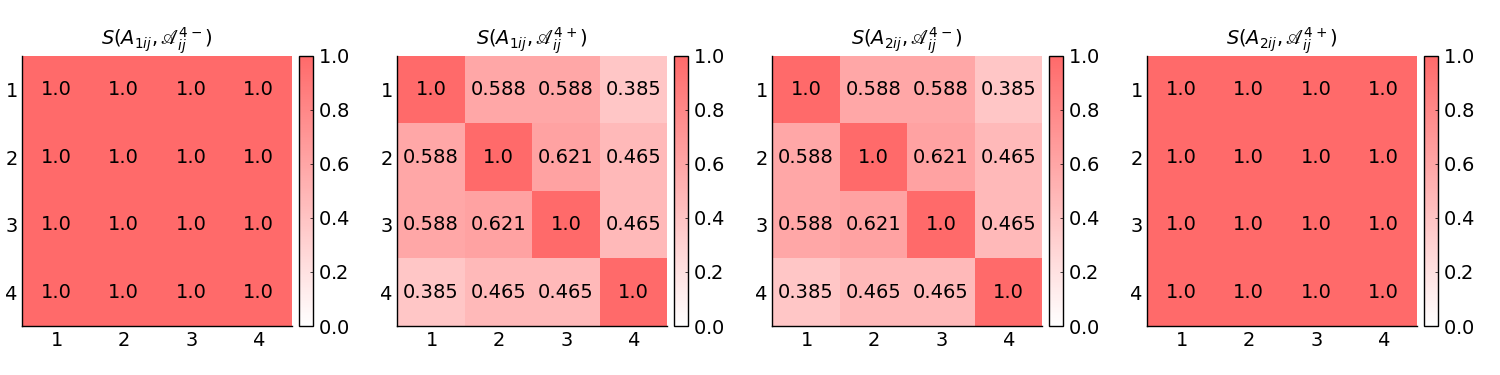

L"$\sigma^{4-} = 0.759$"

L"$\sigma^{4+} = 0.759$"

In [54]:
A₁ = [
    1..1 1..2 (2/3)..(4/3) 1..(4/3)
    (1/2)..1 1..1 (4/9)..1 (2/3)..1
    (3/4)..(3/2) 1..(9/4) 1..1 1..(3/2)
    (3/4)..1 1..(3/2) (2/3)..1 1..1
]
_, n = size(A₁)
A₂ = fill(1..1, (n, n))
for i = 1:n, j = 1:n
    if i == j continue end
    A₂[i,j] = (A₁[i,j].lo * 4 / 5)..(A₁[i,j].hi * 5 / 4)
end

display(L"A_1 = %$(intervalMatrixLaTeXString(A₁))")
display(L"A_2 = %$(intervalMatrixLaTeXString(A₂))")

display(isConsistentIntervalPCM(A₁))
display(isConsistentIntervalPCM(A₂))

plotAll(A₁, A₂, (1500, 375))

<!-- ともに弱い整合性を持ち， $A_{1ij} \subseteq A_{2ij}$

```
A₁ = [
    1..1 2..5 2..4 2..3
    (1/5)..(1/2) 1..1 (1/5)..4 (1/5)..3
    (1/4)..(1/2) (1/4)..5 1..1 (1/4)..3
    (1/3)..(1/2) (1/3)..5 (1/3)..4 1..1
]
A₂ = fill(1..1, size(A₁))
_, n = size(A₁)
for i = 1:n, j = 1:n
    if i == j continue end
    A₂[i,j] = (A₁[i,j].lo * 1/1.1)..(A₁[i,j].hi * 1.1)
end

display(L"A_1 = %$(intervalMatrixLaTeXString(A₁))")
display(L"A_2 = %$(intervalMatrixLaTeXString(A₂))")

display(isConsistentIntervalPCM(A₁))
display(isWeaklyConsistentIntervalPCM(A₁))
display(isConsistentIntervalPCM(A₂))
display(isWeaklyConsistentIntervalPCM(A₂))

plotAll(A₁, A₂)
``` -->

推移率が成り立つ通常の $4 \times 4$ PCM に幅を与えて整合していない行列　2 つを作る

$\begin{bmatrix} 1/2 & 2 & 4 & 4 \\ 1/2 & 1 & 2 & 2 \\ 1/4 & 1/2 & 1 & 1 \\ 1/4 & 1/2 & 1 & 1 \end{bmatrix}$ に自然対数スケールで $[0, 0.03]$ の一様分布に従う乱数の分だけ上下に幅をもたせている

L"$A_1 = \begin{bmatrix} \left[ 1.0, 1.0 \right] & \left[ 1.981, 2.033 \right] & \left[ 3.974, 4.109 \right] & \left[ 3.958, 4.048 \right] \\ \left[ 0.492, 0.505 \right] & \left[ 1.0, 1.0 \right] & \left[ 1.944, 2.048 \right] & \left[ 1.971, 2.045 \right] \\ \left[ 0.243, 0.252 \right] & \left[ 0.488, 0.515 \right] & \left[ 1.0, 1.0 \right] & \left[ 0.983, 1.022 \right] \\ \left[ 0.247, 0.253 \right] & \left[ 0.489, 0.507 \right] & \left[ 0.978, 1.017 \right] & \left[ 1.0, 1.0 \right] \end{bmatrix}$"

L"$A_2 = \begin{bmatrix} \left[ 1.0, 1.0 \right] & \left[ 1.998, 2.01 \right] & \left[ 3.974, 4.05 \right] & \left[ 3.962, 4.041 \right] \\ \left[ 0.497, 0.5 \right] & \left[ 1.0, 1.0 \right] & \left[ 1.945, 2.015 \right] & \left[ 1.942, 2.033 \right] \\ \left[ 0.247, 0.252 \right] & \left[ 0.496, 0.514 \right] & \left[ 1.0, 1.0 \right] & \left[ 0.972, 1.021 \right] \\ \left[ 0.247, 0.252 \right] & \left[ 0.492, 0.515 \right] & \left[ 0.979, 1.029 \right] & \left[ 1.0, 1.0 \right] \end{bmatrix}$"

false

false

"行列を結合して二重区間PCMを作り，整合化"

"\$\\hat{A}_{1} = \\begin{bmatrix} \\left[   1.0, \\left[   1.0,   1.0 \\right],   1.0 \\right] & \\left[ 1.981, \\left[ 1.998,  2.01 \\right], 2.043 \\right] & \\left[ 3.955, \\left[ 3.974,  4.05 \\right], 4.109 \\right] & \\left[ 3.958, \\left[ 3.962, 4.041 \\right], 4.058 \\right] \\\\ \\le" ⋯ 449 bytes ⋯ "ht], 1.023 \\right] \\\\ \\left[ 0.246, \\left[ 0.247, 0.252 \\right], 0.253 \\right] & \\left[ 0.489, \\left[ 0.492, 0.507 \\right], 0.516 \\right] & \\left[ 0.977, \\left[ 0.982, 1.017 \\right], 1.029 \\right] & \\left[   1.0, \\left[   1.0,   1.0 \\right],   1.0 \\right] \\end{bmatrix}\$"

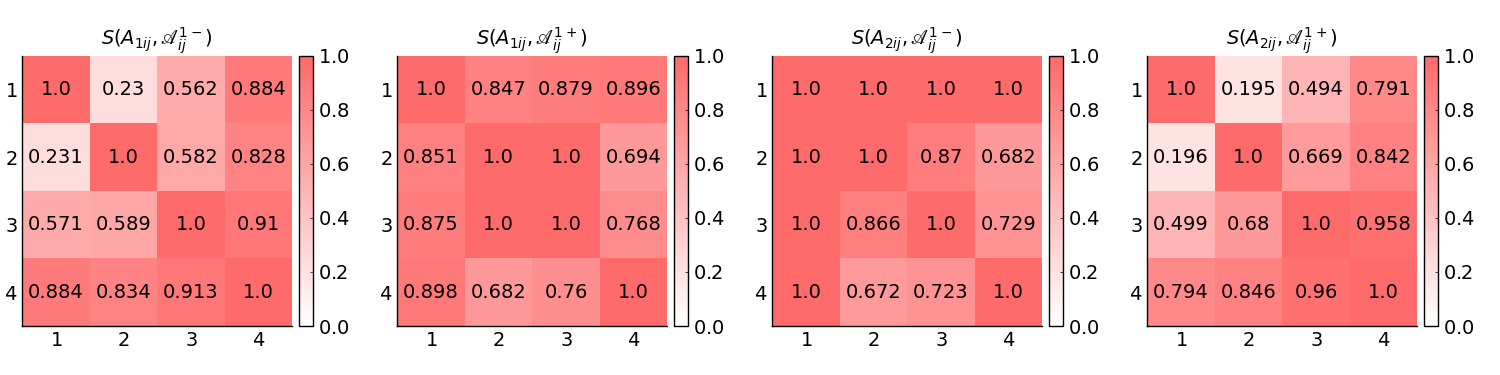

L"$\sigma^{1-} = 0.773$"

L"$\sigma^{1+} = 0.753$"

"整合化しながら結合した重要度を求めて二重区間PCMにする"

"\$\\hat{A}_{2} = \\begin{bmatrix} \\left[   1.0, \\left[   1.0,   1.0 \\right],   1.0 \\right] & \\left[ 1.977, \\left[   2.0,  2.01 \\right], 2.033 \\right] & \\left[ 3.948, \\left[ 3.974, 4.031 \\right], 4.109 \\right] & \\left[ 3.944, \\left[ 3.962, 4.041 \\right], 4.048 \\right] \\\\ \\le" ⋯ 449 bytes ⋯ "ht], 1.024 \\right] \\\\ \\left[ 0.247, \\left[ 0.247, 0.252 \\right], 0.254 \\right] & \\left[ 0.489, \\left[ 0.495, 0.507 \\right], 0.515 \\right] & \\left[ 0.976, \\left[ 0.983, 1.017 \\right], 1.041 \\right] & \\left[   1.0, \\left[   1.0,   1.0 \\right],   1.0 \\right] \\end{bmatrix}\$"

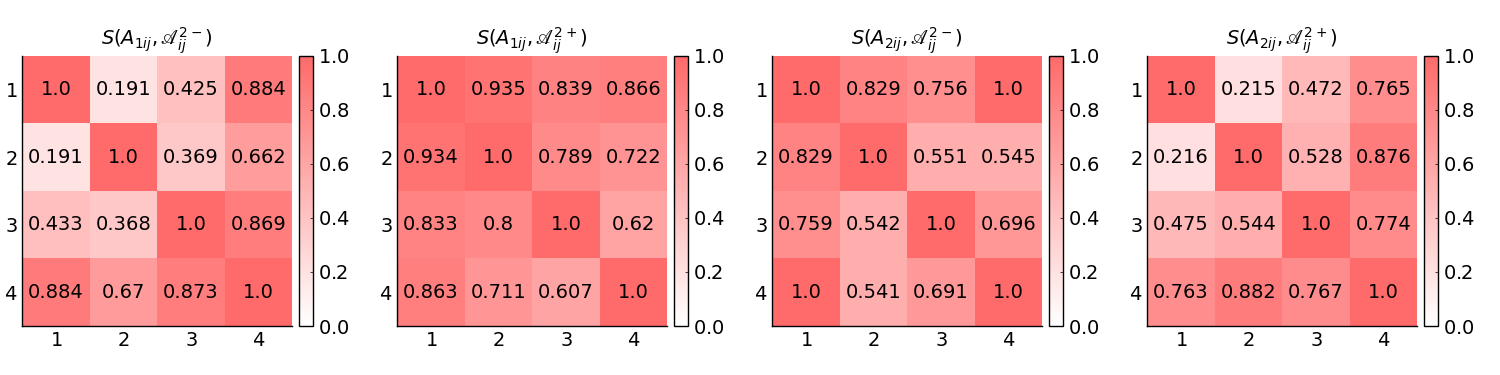

L"$\sigma^{2-} = 0.648$"

L"$\sigma^{2+} = 0.7$"

"DMごとに重要度の上・下近似を求めて重要度として結合し，二重区間PCMにする"

"\$\\hat{A}_{3} = \\begin{bmatrix} \\left[   1.0, \\left[   1.0,   1.0 \\right],   1.0 \\right] & \\left[ 1.981, \\left[ 1.998, 2.021 \\right], 2.033 \\right] & \\left[ 3.948, \\left[ 3.974, 4.057 \\right], 4.071 \\right] & \\left[ 3.962, \\left[ 3.962, 4.055 \\right],  4.07 \\right] \\\\ \\le" ⋯ 449 bytes ⋯ "ht], 1.027 \\right] \\\\ \\left[ 0.246, \\left[ 0.247, 0.252 \\right], 0.252 \\right] & \\left[ 0.488, \\left[ 0.493,  0.51 \\right], 0.511 \\right] & \\left[ 0.973, \\left[  0.98, 1.022 \\right], 1.024 \\right] & \\left[   1.0, \\left[   1.0,   1.0 \\right],   1.0 \\right] \\end{bmatrix}\$"

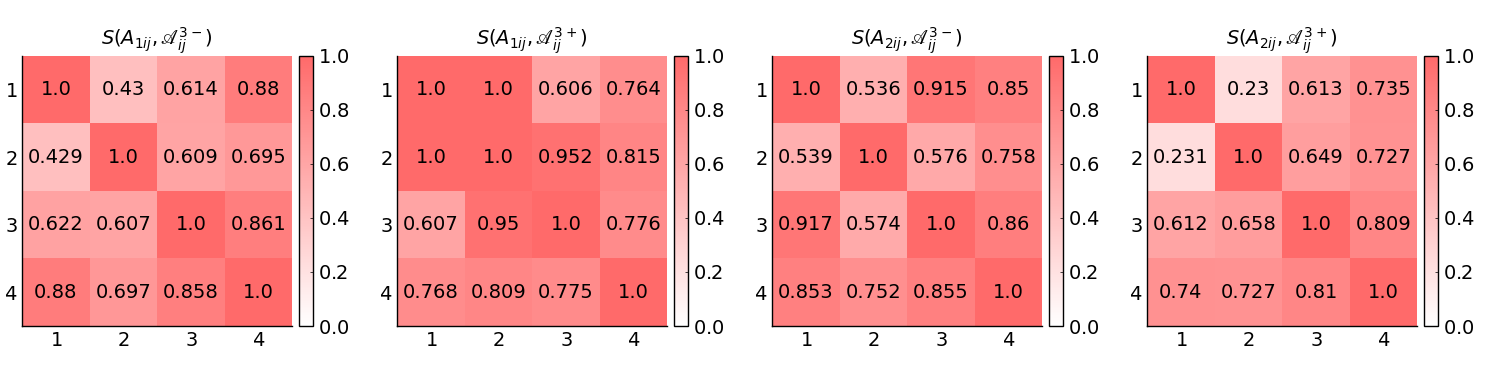

L"$\sigma^{3-} = 0.715$"

L"$\sigma^{3+} = 0.723$"

"DMごとに重要度の上・下近似を求めて二重区間PCMにして，一つの二重区間PCMに結合して整合化"

"\$\\hat{A}_{4} = \\begin{bmatrix} \\left[   1.0, \\left[   1.0,   1.0 \\right],   1.0 \\right] & \\left[ 1.981, \\left[ 1.998, 2.021 \\right], 2.033 \\right] & \\left[ 3.944, \\left[ 3.974,  4.05 \\right], 4.071 \\right] & \\left[ 3.958, \\left[ 3.962, 4.048 \\right], 4.061 \\right] \\\\ \\le" ⋯ 449 bytes ⋯ "ht], 1.027 \\right] \\\\ \\left[ 0.246, \\left[ 0.247, 0.252 \\right], 0.253 \\right] & \\left[ 0.491, \\left[ 0.492, 0.507 \\right], 0.513 \\right] & \\left[ 0.973, \\left[ 0.983, 1.016 \\right], 1.032 \\right] & \\left[   1.0, \\left[   1.0,   1.0 \\right],   1.0 \\right] \\end{bmatrix}\$"

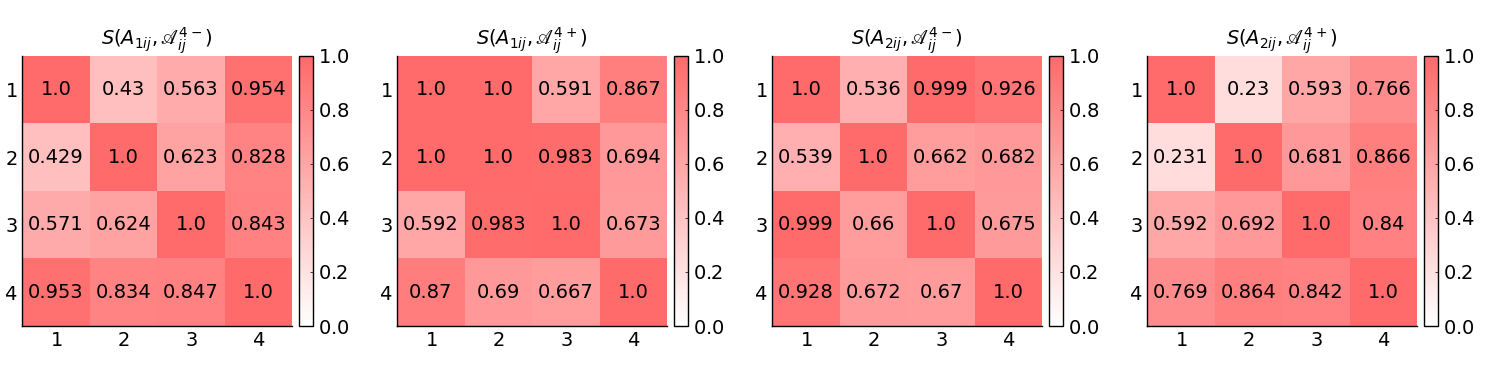

L"$\sigma^{4-} = 0.727$"

L"$\sigma^{4+} = 0.732$"

In [55]:
A = [
    1 2 4 4
    1/2 1 2 2
    1/4 1/2 1 1
    1/4 1/2 1 1
]

A₁ = randamizedIntervalPCM(A, 1234, 3e-2)
A₂ = randamizedIntervalPCM(A, 134, 3e-2)

display(L"A_1 = %$(intervalMatrixLaTeXString(A₁))")
display(L"A_2 = %$(intervalMatrixLaTeXString(A₂))")

display(isConsistentIntervalPCM(A₁))
display(isConsistentIntervalPCM(A₂))

plotAll(A₁, A₂, (1500, 375))

In [56]:
using LinearAlgebra

A = [
    1 2 3 10
    1/2 1 3 8
    1/3 1/3 1 3
    1/10 1/8 1/3 1
]

_, n = size(A)

λ = maximum(real.(filter(e -> imag(e) == 0,eigvals(A))))
(λ - n) / (n - 1)

0.015252586019425252

L"$A_1 = \begin{bmatrix} \left[ 1.0, 1.0 \right] & \left[ 1.477, 2.432 \right] & \left[ 2.334, 3.893 \right] & \left[ 8.353, 12.974 \right] \\ \left[ 0.411, 0.677 \right] & \left[ 1.0, 1.0 \right] & \left[ 2.216, 3.049 \right] & \left[ 6.654, 8.351 \right] \\ \left[ 0.257, 0.428 \right] & \left[ 0.328, 0.451 \right] & \left[ 1.0, 1.0 \right] & \left[ 2.263, 3.309 \right] \\ \left[ 0.077, 0.12 \right] & \left[ 0.12, 0.15 \right] & \left[ 0.302, 0.442 \right] & \left[ 1.0, 1.0 \right] \end{bmatrix}$"

L"$A_2 = \begin{bmatrix} \left[ 1.0, 1.0 \right] & \left[ 1.483, 2.772 \right] & \left[ 2.367, 3.578 \right] & \left[ 8.663, 11.158 \right] \\ \left[ 0.361, 0.674 \right] & \left[ 1.0, 1.0 \right] & \left[ 2.786, 3.835 \right] & \left[ 6.615, 10.334 \right] \\ \left[ 0.279, 0.422 \right] & \left[ 0.261, 0.359 \right] & \left[ 1.0, 1.0 \right] & \left[ 2.648, 4.048 \right] \\ \left[ 0.09, 0.115 \right] & \left[ 0.097, 0.151 \right] & \left[ 0.247, 0.378 \right] & \left[ 1.0, 1.0 \right] \end{bmatrix}$"

false

false

"行列を結合して二重区間PCMを作り，整合化"

"\$\\hat{A}_{1} = \\begin{bmatrix} \\left[   1.0, \\left[   1.0,   1.0 \\right],   1.0 \\right] & \\left[ 1.073, \\emptyset, 2.772 \\right] & \\left[ 2.334, \\emptyset, 5.358 \\right] & \\left[ 8.353, \\emptyset, 14.677 \\right] \\\\ \\left[ 0.361, \\emptyset, 0.932 \\right] & \\left[   1.0, \\" ⋯ 235 bytes ⋯ "0,   1.0 \\right],   1.0 \\right] & \\left[ 1.924, \\emptyset, 5.212 \\right] \\\\ \\left[ 0.068, \\emptyset,  0.12 \\right] & \\left[ 0.097, \\emptyset, 0.236 \\right] & \\left[ 0.192, \\emptyset,  0.52 \\right] & \\left[   1.0, \\left[   1.0,   1.0 \\right],   1.0 \\right] \\end{bmatrix}\$"

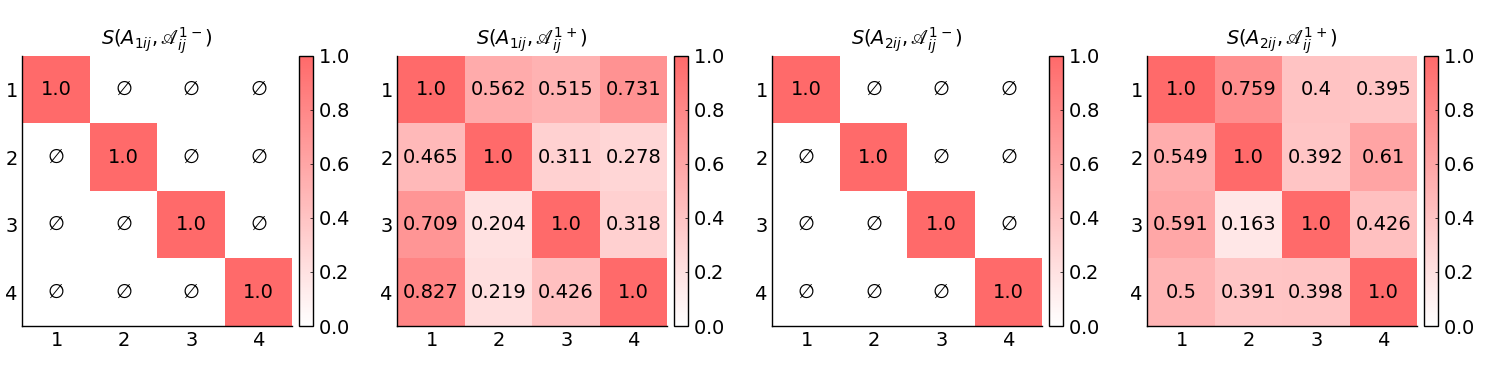

L"$\sigma^{1-} = 0.0$"

L"$\sigma^{1+} = 0.464$"

"整合化しながら結合した重要度を求めて二重区間PCMにする"

"\$\\hat{A}_{2} = \\begin{bmatrix} \\left[   1.0, \\left[   1.0,   1.0 \\right],   1.0 \\right] & \\left[ 1.477, \\left[ 1.483, 1.483 \\right], 2.772 \\right] & \\left[ 2.334, \\left[ 3.578, 3.578 \\right], 6.841 \\right] & \\left[ 8.353, \\left[ 9.868, 9.868 \\right], 18.434 \\right] \\\\ \\l" ⋯ 451 bytes ⋯ "ht], 6.541 \\right] \\\\ \\left[ 0.054, \\left[ 0.101, 0.101 \\right],  0.12 \\right] & \\left[ 0.097, \\left[  0.15,  0.15 \\right], 0.275 \\right] & \\left[ 0.153, \\left[ 0.363, 0.363 \\right], 0.678 \\right] & \\left[   1.0, \\left[   1.0,   1.0 \\right],   1.0 \\right] \\end{bmatrix}\$"

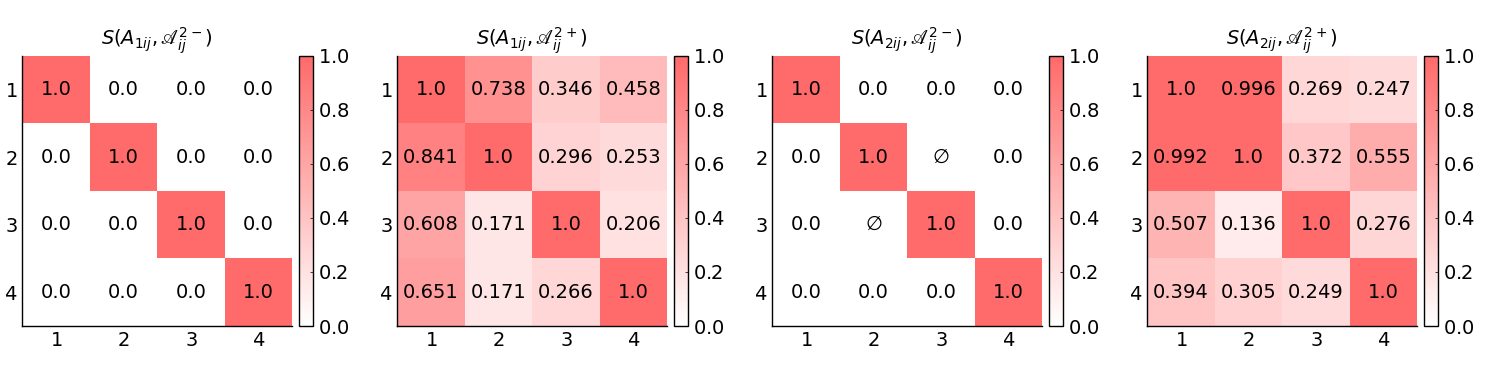

L"$\sigma^{2-} = 0.0$"

L"$\sigma^{2+} = 0.429$"

"DMごとに重要度の上・下近似を求めて重要度として結合し，二重区間PCMにする"

"\$\\hat{A}_{3} = \\begin{bmatrix} \\left[   1.0, \\left[   1.0,   1.0 \\right],   1.0 \\right] & \\left[ 1.477, \\left[ 1.568, 1.773 \\right],  2.41 \\right] & \\left[ 2.341, \\left[ 3.837, 3.929 \\right], 4.762 \\right] & \\left[ 10.994, \\left[ 11.667, 12.922 \\right], 13.003 \\right] \\\\" ⋯ 453 bytes ⋯ "ht], 5.175 \\right] \\\\ \\left[ 0.077, \\left[ 0.077, 0.086 \\right], 0.091 \\right] & \\left[ 0.122, \\left[ 0.122,  0.15 \\right], 0.206 \\right] & \\left[ 0.193, \\left[ 0.301, 0.333 \\right], 0.404 \\right] & \\left[   1.0, \\left[   1.0,   1.0 \\right],   1.0 \\right] \\end{bmatrix}\$"

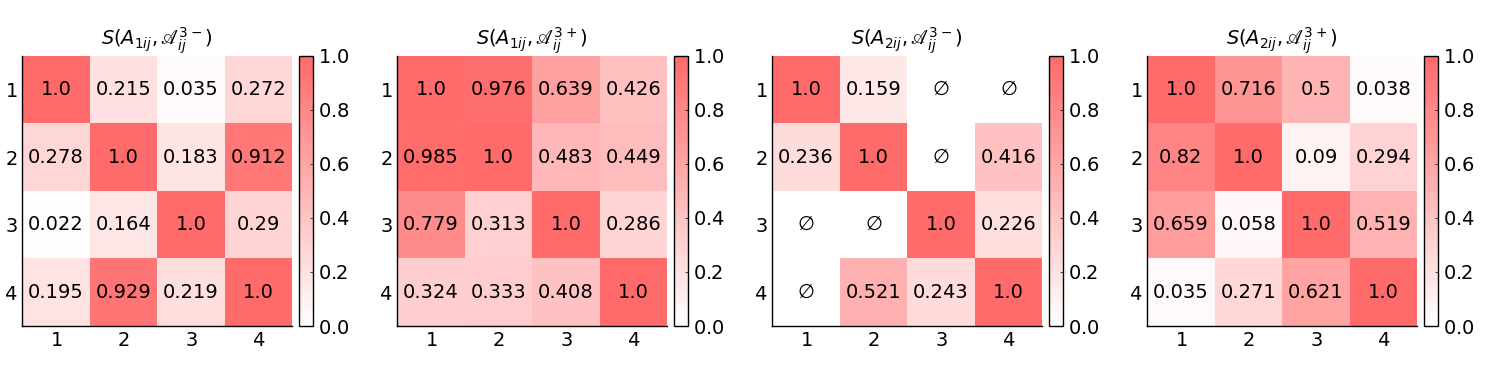

L"$\sigma^{3-} = 0.23$"

L"$\sigma^{3+} = 0.459$"

"DMごとに重要度の上・下近似を求めて二重区間PCMにして，一つの二重区間PCMに結合して整合化"

"\$\\hat{A}_{4} = \\begin{bmatrix} \\left[   1.0, \\left[   1.0,   1.0 \\right],   1.0 \\right] & \\left[ 1.483, \\emptyset, 2.432 \\right] & \\left[ 2.367, \\emptyset, 4.762 \\right] & \\left[ 8.663, \\emptyset, 13.043 \\right] \\\\ \\left[ 0.411, \\emptyset, 0.674 \\right] & \\left[   1.0, \\" ⋯ 234 bytes ⋯ "0,   1.0 \\right],   1.0 \\right] & \\left[ 1.888, \\emptyset, 5.191 \\right] \\\\ \\left[ 0.077, \\emptyset, 0.115 \\right] & \\left[  0.12, \\emptyset, 0.271 \\right] & \\left[ 0.193, \\emptyset,  0.53 \\right] & \\left[   1.0, \\left[   1.0,   1.0 \\right],   1.0 \\right] \\end{bmatrix}\$"

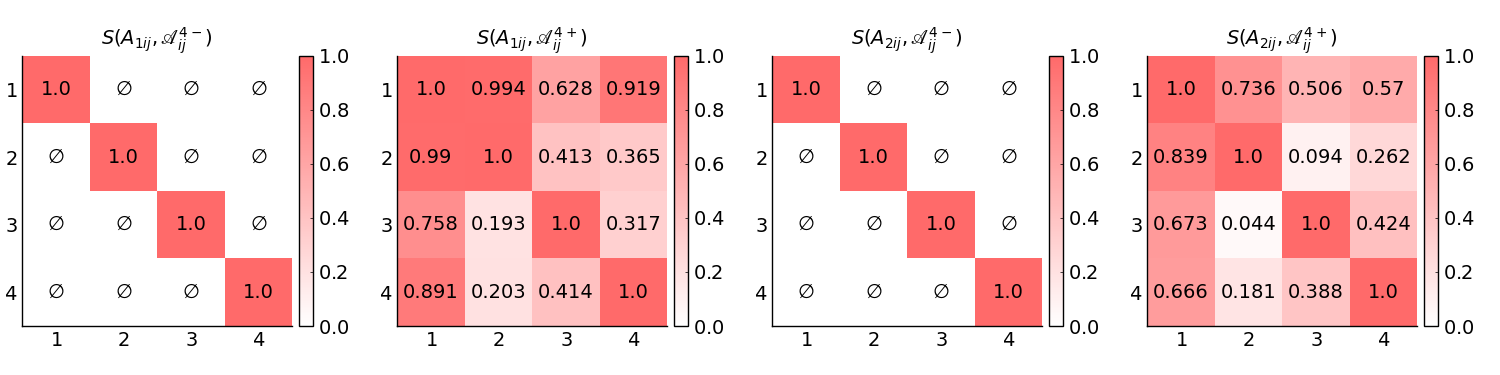

L"$\sigma^{4-} = 0.0$"

L"$\sigma^{4+} = 0.519$"

In [57]:
A = [
    1 2 3 10
    1/2 1 3 8
    1/3 1/3 1 3
    1/10 1/8 1/3 1
]

A₁ = randamizedIntervalPCM(A, 124, 3.5e-1)
A₂ = randamizedIntervalPCM(A, 4, 3.5e-1)

display(L"A_1 = %$(intervalMatrixLaTeXString(A₁))")
display(L"A_2 = %$(intervalMatrixLaTeXString(A₂))")

display(isConsistentIntervalPCM(A₁))
display(isConsistentIntervalPCM(A₂))

plotAll(A₁, A₂, (1500, 375))

### 整合した区間 PCM 関連

- 重要度が存在する同じ区間 PCM 2 つ
    - 全て同じ出力
        - 手法 3 は $t_k^-, t_k^+$ の任意性があるので違う値を出してくる可能性がある
- 重要度が存在する各成分に包含関係が成り立つ 2 つの区間 PCM
    - 手法 3 のみ違う値
        - $t_k^-, t_k^+$ の任意性による
- $t_k^- = t_k^+$ にすればおそらく揃う
    - $\max\{t_k^{\text{L}-}, t_l^{\text{L}+} ~ | ~ k \in M^{'}, l \in M\} \leq t \leq \min\{t_k^{\text{U}-}, t_l^{\text{U}+} ~ | ~ k \in M^{'}, l \in M\}$
- 重要度が存在して唯一である PCM 2 つであれば全て揃うはず

### 与えられた区間 PCM との包含関係

- 手法 2, 3 の内側は数値例から $\mathscr{A}^- \subseteq A_k, k \in M$ が成り立たないことが確定
    - 手法 2 は $A_k$ を修正して得られた重みで二重区間 PCM を作っている
        - 修正を反映した $A_k$ との包含関係は保証されているはず
- 外側は不明だが手法 3 以外は直感的には大丈夫そう
- 手法 1, 4 に関しては包含関係が破れる操作をしていないので大丈夫なはず
    - 包含関係が成り立つようにできない場合は空集合になるはず

### 一致度

- 4 つともあまり差がないので数を増やして統計をとってみないと何とも言えない
    - いくつかのケースを想定して区間 PCM を作成してシミュレーション

- 手法 4 の intersection を取るところで内が空集合のものを無視するのはどうだろうか
    - PCM が違えば定数倍の意味も変わるため， $t$ を揃える正当性は無い？

## 数値例どうする
- 同じ PCM の例で言えることは包含関係にある PCM で言えることの特殊例
    - 条件を厳しくしても特に言えることは増えていないので包含関係にあるもの 2 つ
        - 重要度の唯一性が担保されているもの→されていないものと進めるのはあり
- 典型例は 2 つと 3 つで言えることが変わらない
    - 4 つともかなり接戦
        - 一つ増やしたくらいでもとの PCM との一致度の順位付けはできない
    - もとの PCM との包含関係の議論が十分できるだけの情報が含まれている数値例 2 つで良い